## Data

In [26]:
import ccxt
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timezone
import matplotlib.pyplot as plt

EXCHANGE_MAP = {
    "binance": ccxt.binance,
    "kraken": ccxt.kraken,
    "gemini": ccxt.gemini,
    "coinbase": ccxt.coinbase,  # ccxt "coinbase" is Coinbase Exchange (Advanced Trade)
}

def get_exchange(name: str):
    name = name.lower().strip()
    if name not in EXCHANGE_MAP:
        raise ValueError(f"Unknown exchange '{name}'. Choose: {list(EXCHANGE_MAP.keys())}")
    ex = EXCHANGE_MAP[name]({"enableRateLimit": True})
    ex.load_markets()
    return ex

def fetch_ohlcv_history(exchange_name: str, symbol: str, timeframe: str, since_iso: str, max_bars: int = 10000):
    ex = get_exchange(exchange_name)
    since_ms = ex.parse8601(since_iso)

    all_rows = []
    while len(all_rows) < max_bars:
        batch = ex.fetch_ohlcv(symbol, timeframe=timeframe, since=since_ms, limit=1000)
        if not batch:
            break
        all_rows.extend(batch)
        since_ms = batch[-1][0] + 1  # move forward 1ms to avoid duplicates

        # safety: stop if exchange keeps returning same last timestamp
        if len(batch) < 2:
            break

    df = pd.DataFrame(all_rows, columns=["timestamp_ms","open","high","low","close","volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp_ms"], unit="ms", utc=True)
    df = df.drop(columns=["timestamp_ms"]).drop_duplicates(subset=["timestamp"]).sort_values("timestamp")
    return df[["timestamp","open","high","low","close","volume"]]


def fetch_spot_price(exchange_name: str, symbol: str):
    ex = get_exchange(exchange_name)
    t = ex.fetch_ticker(symbol)
    # ticker fields vary a bit; 'last' is usually the spot last traded price
    return {
        "exchange": exchange_name,
        "symbol": symbol,
        "timestamp": datetime.fromtimestamp(t["timestamp"]/1000, tz=timezone.utc) if t.get("timestamp") else None,
        "last": t.get("last"),
        "bid": t.get("bid"),
        "ask": t.get("ask"),
        "quoteVolume": t.get("quoteVolume"),
    }

def fetch_ohlcv(exchange_name: str, symbol: str, timeframe: str = "1h", limit: int = 500):
    """
    Returns a DataFrame with columns: timestamp, open, high, low, close, volume (UTC)
    """
    ex = get_exchange(exchange_name)

    # Some exchanges use different symbol formats. We'll check it's listed.
    if symbol not in ex.markets:
        # quick heuristic alternatives
        raise ValueError(
            f"Symbol '{symbol}' not found on {exchange_name}. "
            f"Try exchange-specific formats (e.g. Kraken: 'BTC/USD' or 'XBT/USD')."
        )

    ohlcv = ex.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=["timestamp_ms", "open", "high", "low", "close", "volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp_ms"], unit="ms", utc=True)
    df = df.drop(columns=["timestamp_ms"])
    return df[["timestamp", "open", "high", "low", "close", "volume"]]

def save_csv(df: pd.DataFrame, path: str):
    df.to_csv(path, index=False)
    return path

if __name__ == "__main__":
    # Pick exchange + symbol:
    # Binance:  "BTC/USDT"
    # Coinbase: "BTC/USD"
    # Gemini:   "BTC/USD"
    # Kraken:   often "BTC/USD" works, but sometimes needs "XBT/USD"
    exchange = "coinbase"
    symbol = "BTC/USD"

    price = fetch_spot_price(exchange, symbol)
    print("Latest ticker:", price)

    df = fetch_ohlcv(exchange, symbol, timeframe="1h", limit=1000)
    #print(df.tail())

    #out = save_csv(df, f"{exchange}_{symbol.replace('/', '')}_1h.csv")
    #print("Saved:", out)


Latest ticker: {'exchange': 'coinbase', 'symbol': 'BTC/USD', 'timestamp': datetime.datetime(2026, 1, 27, 16, 51, 10, 989000, tzinfo=datetime.timezone.utc), 'last': 88665.47, 'bid': 88665.47, 'ask': 88665.48, 'quoteVolume': None}


In [12]:
price_data = fetch_ohlcv_history(exchange_name = "coinbase", symbol = "BTC/USD", timeframe = "1m", since_iso = "2025-01-01T00:00:00Z", max_bars = 10000)

In [266]:
# Fetch historical data for a stock (e.g., Apple)
hist_data = yf.download("AAPL", start="2000-01-01", end="2025-01-01")
#data.to_csv('SHIB.csv', index=False)

[*********************100%***********************]  1 of 1 completed


## research

### Stationary action.
1. Measure the potential energy 

   a. Calculate confidence interval for potential energy of the asset. \
   b. Buy when price dips below confidence interval. \
   c. Sell when price dips above confidence interval.

### Convergence/Divergence.
1. Measure convergence/Divergence of prices

   a. Measure intraday range, measure first diff and calculate con/div
   b. Measure moving averages, calculate con/div
   c. Measure returns distribution, calculate con/div



### Current plan
1. low volatility
2. Z-score on price with moving average

if low vol and z <-2 buy
if low vol and z > -0.5 sell

In [325]:
import numpy as np
import pandas as pd

def rolling_linreg_slope(y: pd.Series, window: int = 20) -> pd.Series:
    """
    Rolling OLS slope of y ~ a + b*x over a window, where x = 0..window-1.
    Returns slope per bar.
    """
    y = y.astype(float)
    x = np.arange(window, dtype=float)

    x_mean = x.mean()
    x_demean = x - x_mean
    denom = np.sum(x_demean**2)  # constant for a fixed window

    def slope_last_window(y_window: np.ndarray) -> float:
        y_demean = y_window - y_window.mean()
        return float(np.dot(x_demean, y_demean) / denom)

    return y.rolling(window, min_periods=window).apply(slope_last_window, raw=True)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [503]:
df = pd.DataFrame()
df["Price"] = hist_data.Open
df["Returns"] = (df['Price'] / df['Price'].shift(1)) - 1
df['log_return'] = np.log(df['Price'] / df['Price'].shift(1))

# volatility indicators

df['daily_vol'] = df['log_return'].rolling(window=21).std()
df['ewma_vol'] = df['log_return'].ewm(span=21, adjust=False).std()
# linear regression on volatility
df["vol_slope"] = rolling_linreg_slope(df["ewma_vol"], window=21)
# first and second derivative of volatility
df["Dvol"] = (df['ewma_vol'] - df['ewma_vol'].shift(1))
df["D2vol"] = (df['Dvol'] - df['Dvol'].shift(1))
#volatility of volatility
df["vov"] = df['ewma_vol'].ewm(span=21, adjust=False).std()
#slope of vov
df["vov_slope"] = rolling_linreg_slope(df["vov"], window=21)

df["log_vol"] = np.log(df["ewma_vol"])
z_vol = (df["log_vol"] - df["log_vol"].ewm(span=21, adjust=False).mean()) / df["log_vol"].ewm(span=21, adjust=False).std()

df["vol_sign1"] = df['ewma_vol'].rolling(window=21).min()
df["vol_sign2"] = df['ewma_vol'].rolling(window=21).max()

vol_signal = [0]
for i in range(len(df)):
    if df["ewma_vol"][i-1] == df["vol_sign1"][i] and df["ewma_vol"][i] != df["vol_sign1"][i]:
        vol_signal.append(1)
    elif df["ewma_vol"][i-1] == df["vol_sign2"][i] and df["ewma_vol"][i] != df["vol_sign2"][i]:
        vol_signal.append(-1)
    else:
        vol_signal.append(0)

tr = [0]
for i in range(1,len(df)):
    tr1 = hist_data.High.iloc[i,0] - hist_data.Low.iloc[i,0]
    tr2 = abs(hist_data.High.iloc[i,0] - hist_data.Close.iloc[i-1,0])
    tr3 = abs(hist_data.Low.iloc[i,0] - hist_data.Close.iloc[i-1,0])

    
    tr.append(max(tr1,tr2,tr3))

df["TR"] = tr
df["ATR"] = df["TR"].rolling(window=21).mean()

# intraday range
df["IR"] = hist_data.High - hist_data.Low
df["IR-ret"] = (df['IR'] / df['IR'].shift(1)) - 1
df["IR-ret-MA"] = df["IR-ret"].ewm(span=21, adjust=False).mean()
df["IR-MA"] = df["IR"]/df["Price"]#df["IR"].ewm(span=10, adjust=False).mean()
df["IR-signal"] = 0
for i in range(len(df)):
    if df["IR-ret-MA"][i] < 0.1:
        df["IR-signal"][i] = 1
    elif df["IR-ret-MA"][i] > 0.11:
        df["IR-signal"][i] = -1

df = df[21:]
df = df.reset_index(drop = True)

In [356]:
#df = df[2:]
#df = df.reset_index(drop = True)

S1 = sigmoid(-df["vol_slope"] / df["ewma_vol"])
S2 = []
for i in range(len(df)):
    if (df["D2vol"][i] > 0 and df["Dvol"][i] < 0):
        S2.append(float(1))
    else:
        S2.append(float(0))

S2 = pd.DataFrame(S2)
S3 = sigmoid(-df["vov_slope"] / df["vov"])
score = 0.45*S1 + 0.30*S2[0] + 0.25*S3
score

0       0.654319
1       0.654170
2       0.353250
3       0.352810
4       0.652309
          ...   
6261    0.350425
6262    0.650143
6263    0.649975
6264    0.349626
6265    0.349198
Length: 6266, dtype: float64

jumps or "slowdowns" in vov and ewma_vol
peaks in Dvol and D2vol

when ewma_vol[-1] touches vol_sign1/2 and ewma_vol[0] starts heading in opposite direction of vol_sign1/2

In [513]:
vol_signal = [0]
for i in range(1,len(df)):
    if df["ewma_vol"][i-1] == df["vol_sign1"][i] and df["ewma_vol"][i] > df["vol_sign1"][i]:
        vol_signal.append(1)
    elif df["ewma_vol"][i-1] == df["vol_sign2"][i] and df["ewma_vol"][i] < df["vol_sign2"][i]:
        vol_signal.append(-1)
    else:
        vol_signal.append(0)

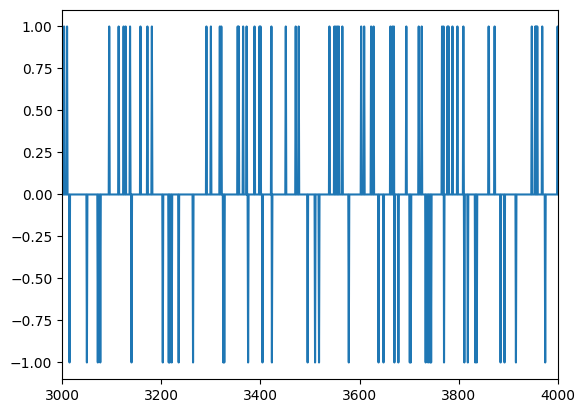

In [519]:
plt.plot(vol_signal)
plt.xlim(3000,4000)
plt.show()

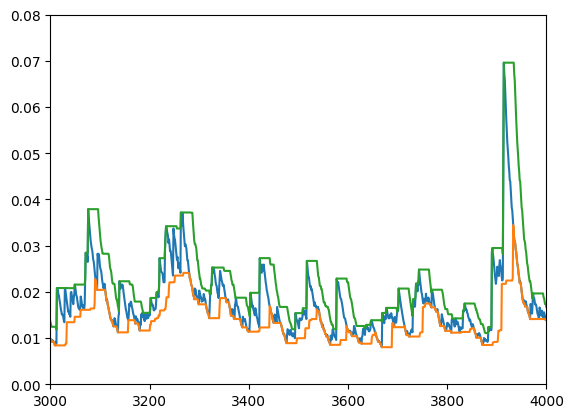

In [525]:
plt.plot(df["ewma_vol"])
plt.plot(df["vol_sign1"])
plt.plot(df["vol_sign2"])
plt.xlim(3000,4000)
plt.ylim(0,0.08)
plt.show()

(4070.0, 4290.0)

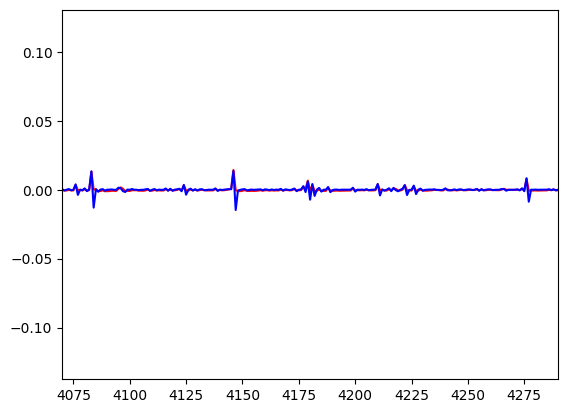

In [502]:
#should measure slowdowns or peaks
#plt.axvline(x=3264, color='black', label='axvline - full height')
#plt.axvline(x=3322, color='black', label='axvline - full height')
#plt.plot(df["ewma_vol"]/10, color = "black")
#plt.plot(df["vov"]) #df[vov] > 0.01?
plt.plot(df["Dvol"], color = "red") #df[dvol] > local mean + 2sigma??
plt.plot(df["D2vol"], color = "blue") #df[d2vol] > 0 -> df[d2vol] < 0?
plt.xlim(4070,4290) # 2126-2130? 2180-2190?
#plt.ylim(-0.0025, 0)

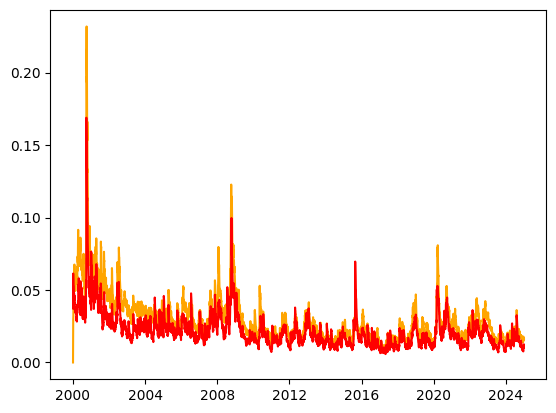

In [316]:
#plt.plot(df["Returns"], color = "black")

#plt.plot(df["daily_vol"], color = "black")
#plt.plot(df["annual_vol"], color = "orange")
plt.plot(df["ATR"]/df["Price"], color = "orange")

plt.show()

In [271]:
df = pd.DataFrame()
df["Price"] = hist_data.Open
df["IR"] = hist_data.High - hist_data.Low
df["IR-ret"] = (df['IR'] / df['IR'].shift(1)) - 1
df["IR-ret-MA"] = df["IR-ret"].ewm(span=100, adjust=False).mean()
df["IR-MA"] = df["IR"]/df["Price"]#df["IR"].ewm(span=10, adjust=False).mean()
df["IR-signal"] = 0
for i in range(len(df)):
    if df["IR-ret-MA"][i] < 0.1:
        df["IR-signal"][i] = 1
    elif df["IR-ret-MA"][i] > 0.11:
        df["IR-signal"][i] = -1

df["m-6"] = df["Price"].ewm(span=360, adjust=False).mean()
df["m-day"] = df["Price"].ewm(span=1440, adjust=False).mean()
df["m-2day"] = df["Price"].ewm(span=2880, adjust=False).mean()

df["m"] = df["Price"].ewm(span=2880, adjust=False).mean()
df["s"] = df['Price'].ewm(span=2880, adjust=False).std()
df["U"] = (df["Price"] - df["m"])**2 / (2*df["s"])

df["z"] = (df["Price"] - df["m"])/df["s"]

df['log_return'] = np.log(df['Price'] / df['Price'].shift(1))
df['daily_vol'] = df['log_return'].rolling(window=2880).std()
df['annual_vol'] = df['daily_vol'] * np.sqrt(252)
df['ewma_vol'] = df['log_return'].ewm(span=2880, adjust=False).std() * np.sqrt(252)

df = df[21:]
df = df.reset_index(drop = True)
df

,Price,IR,IR-ret,IR-ret-MA,IR-MA,IR-signal,m-6,m-day,m-2day,m,s,U,z,log_return,daily_vol,annual_vol,ewma_vol
0,0.755400,0.038426,0.025000,-0.057097,0.050869,1,0.785674,0.786148,0.786237,0.786237,0.031064,0.015306,-0.992676,-0.031747,NaN,NaN,0.659937
1,0.752119,0.029992,-0.219497,-0.060312,0.039876,1,0.785488,0.786101,0.786213,0.786213,0.030789,0.018877,-1.107345,-0.004353,NaN,NaN,0.649970
2,0.779298,0.047799,0.593726,-0.047361,0.061335,1,0.785454,0.786092,0.786208,0.786208,0.030130,0.000792,-0.229335,0.035500,NaN,NaN,0.635111
3,0.809758,0.062325,0.303901,-0.040405,0.076967,1,0.785588,0.786125,0.786225,0.786225,0.029694,0.009326,0.792549,0.038342,NaN,NaN,0.621380
4,0.854745,0.036551,-0.413540,-0.047794,0.042762,1,0.785971,0.786220,0.786272,0.786272,0.030691,0.076383,2.231047,0.054067,NaN,NaN,0.610590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6263,254.339701,2.906851,0.327274,0.103192,0.011429,0,201.846601,146.099926,104.493600,104.493600,73.981123,151.753940,2.025464,0.002822,0.018104,0.287398,0.307948
6264,257.027510,2.458880,-0.154109,0.098097,0.009567,1,202.152313,146.253885,104.599489,104.599489,74.064530,156.851745,2.058043,0.010512,0.018105,0.287403,0.307865
6265,256.669129,5.614621,1.283406,0.121568,0.021875,-1,202.454345,146.407134,104.705057,104.705057,74.147123,155.724715,2.049494,-0.001395,0.018105,0.287404,0.307760
6266,251.094363,2.737618,-0.512413,0.109014,0.010903,0,202.723819,146.552432,104.806681,104.806681,74.221641,144.163385,1.970957,-0.021959,0.018109,0.287471,0.307808


(0.0, 0.4)

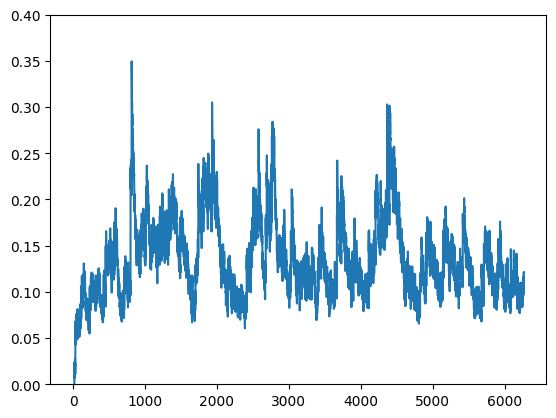

In [287]:
plt.plot(df["IR-ret-MA"])
#plt.xlim(5000,5500)
plt.ylim(0,0.4)

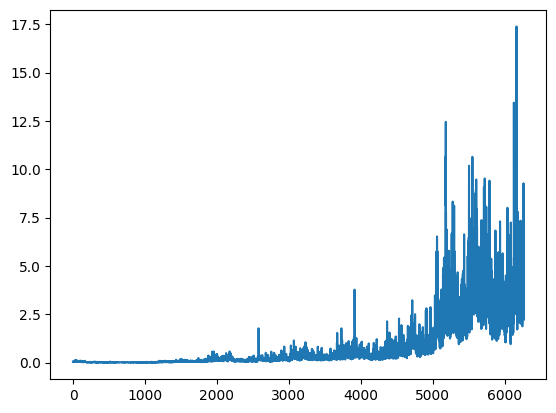

In [270]:
#plt.plot(df["Price"])
plt.plot(df["IR"])
#plt.plot(df["IR-MA"])
#plt.xlim(1440,1450)
#plt.ylim(0,10)

(-100.0, 1400.0)

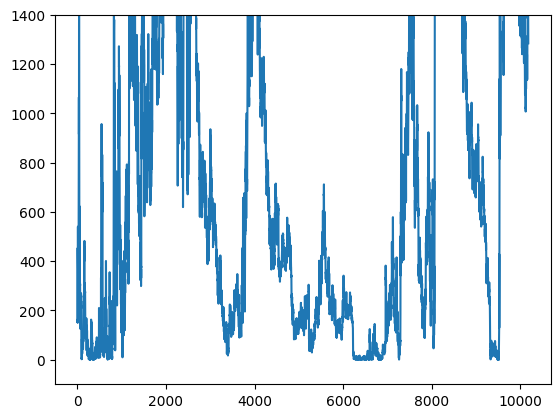

In [201]:
plt.plot(df["U"])
#plt.xlim(1440,1450)
plt.ylim(-100,1400)

In [157]:
def low_vol(df, i):
    vol_col = "daily_vol"
    # ---- precompute thresholds once (your condition uses these means) ----
    vol_mean = df[vol_col].mean()
    vol_sqrt_mean = np.sqrt(df[vol_col]).mean()
    vol_thresh = vol_mean + 2 * vol_sqrt_mean
    vol = float(df[vol_col].iloc[i])
    if vol < vol_thresh:
        return(True)
    else:
        return(False)

#def conv_div(df, i):
 #   returns convergence
  #  intra_day convergence
    

In [170]:
def mean_buy(df, i):
    #buy
    # price < m-6 and price < m-day
    # m-6 > m-day
    if df["Price"][i] < df["m-6"][i] and df["Price"][i] < df["m-day"][i]:
        if df["m-6"][i] > df["m-day"][i]: # and df["m-day"][i] > df["m-2day"][i]:
            return(True)
    else:
        return(False)

def mean_sell(df, i):
    #sell
    # price < m-6
    # price > m-day and price > m-2day
    if df["Price"][i] < df["m-6"][i]:
        if df["Price"][i] > df["m-day"][i] and df["Price"][i] > df["m-2day"][i]:
            return(True)
    else:
        return(False)

def z_score(df, i):
    if df["z"][i] <= 0:
        return("Buy")
    elif df["z"][i] >= 1:
        return("Sell")

In [272]:
import warnings

warnings.filterwarnings('ignore') # Hide all warnings

df["conditions"] = False
df["signal"] = ""
df["MA_buy"] = False
df["MA_sell"] = False

for i in range(len(df)):
    if df["IR-signal"][i] == 1: #low_vol(df,i) == True and 
        df["conditions"][i] = True
        
    df["signal"][i] = z_score(df,i)
    #df["MA_buy"][i] = mean_buy(df, i)
    #df["MA_sell"][i] = mean_sell(df, i)

df

,Price,IR,IR-ret,IR-ret-MA,IR-MA,IR-signal,m-6,m-day,m-2day,m,...,U,z,log_return,daily_vol,annual_vol,ewma_vol,conditions,signal,MA_buy,MA_sell
0,0.755400,0.038426,0.025000,-0.057097,0.050869,1,0.785674,0.786148,0.786237,0.786237,...,0.015306,-0.992676,-0.031747,NaN,NaN,0.659937,True,Buy,False,False
1,0.752119,0.029992,-0.219497,-0.060312,0.039876,1,0.785488,0.786101,0.786213,0.786213,...,0.018877,-1.107345,-0.004353,NaN,NaN,0.649970,True,Buy,False,False
2,0.779298,0.047799,0.593726,-0.047361,0.061335,1,0.785454,0.786092,0.786208,0.786208,...,0.000792,-0.229335,0.035500,NaN,NaN,0.635111,True,Buy,False,False
3,0.809758,0.062325,0.303901,-0.040405,0.076967,1,0.785588,0.786125,0.786225,0.786225,...,0.009326,0.792549,0.038342,NaN,NaN,0.621380,True,None,False,False
4,0.854745,0.036551,-0.413540,-0.047794,0.042762,1,0.785971,0.786220,0.786272,0.786272,...,0.076383,2.231047,0.054067,NaN,NaN,0.610590,True,Sell,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6263,254.339701,2.906851,0.327274,0.103192,0.011429,0,201.846601,146.099926,104.493600,104.493600,...,151.753940,2.025464,0.002822,0.018104,0.287398,0.307948,False,Sell,False,False
6264,257.027510,2.458880,-0.154109,0.098097,0.009567,1,202.152313,146.253885,104.599489,104.599489,...,156.851745,2.058043,0.010512,0.018105,0.287403,0.307865,True,Sell,False,False
6265,256.669129,5.614621,1.283406,0.121568,0.021875,-1,202.454345,146.407134,104.705057,104.705057,...,155.724715,2.049494,-0.001395,0.018105,0.287404,0.307760,False,Sell,False,False
6266,251.094363,2.737618,-0.512413,0.109014,0.010903,0,202.723819,146.552432,104.806681,104.806681,...,144.163385,1.970957,-0.021959,0.018109,0.287471,0.307808,False,Sell,False,False


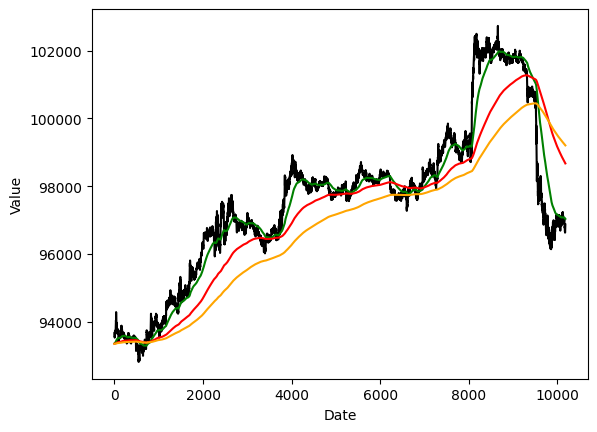

In [147]:
plt.plot(df.Price, color = "Black") # price > m-6 > m-day > m-2day = sell
plt.plot(df["m-6"], color = "Green") # price < m-6 < m-day & price > m-2day = buy
plt.plot(df["m-day"], color = "Red")
plt.plot(df["m-2day"], color = "Orange")
plt.xlabel('Date')
plt.ylabel('Value')
#plt.xlim(5000,7500)
#plt.ylim(97000,98500)
plt.show()

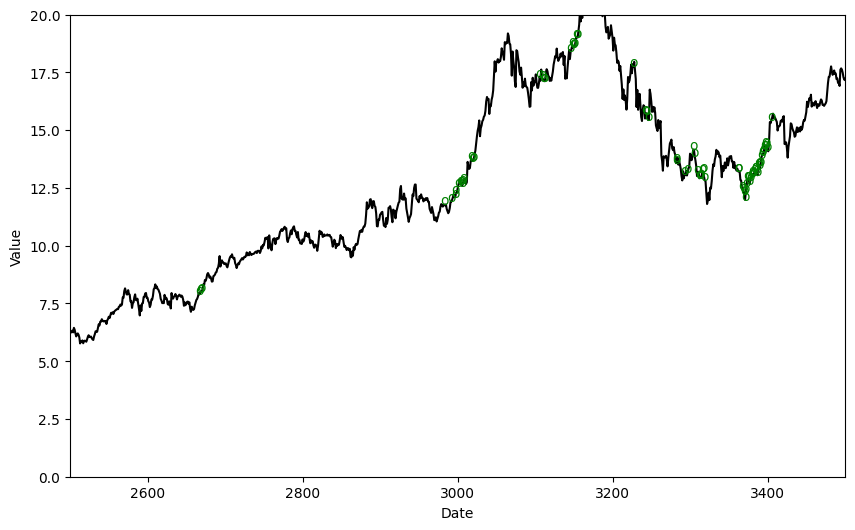

In [292]:
df['long_signal'] = (df["conditions"] == True) #& (df["signal"] == "Buy") #& (df["MA_buy"] == True)
# Generate short (sell) signals
df['short_signal'] = (df["conditions"] == False) #& (df["signal"] == "Sell") # & (df["MA_sell"] == True)

fig, ax = plt.subplots(figsize=(10, 6))

# Add arrows for long (buy) signals
long_signal_dates = df[df['long_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, df.loc[date, 'Price']), color='green', fontsize=10, ha='center')

# Add arrows for short (sell) signals
short_signal_dates = df[df['short_signal']].index
#for date in short_signal_dates:
    #ax.annotate('x', xy=(date, df.loc[date, 'Price']), color='red', fontsize=10, ha='center')

# Plot the time series
plt.plot(df.Price, color = "Black")
plt.xlabel('Date')
plt.ylabel('Value')
plt.xlim(2500,3500)
plt.ylim(0,20)
plt.show()

In [263]:
import numpy as np
import pandas as pd

def run_strategy_and_sharpe(
    df: pd.DataFrame,
    price_col="Price",
    vol_col="daily_vol",
    z_col="z",
    initial_cash=100.0,
    sell_fee=0.005,         # 0.5% fee on sells, as in your code
    periods_per_year=252,   # crypto trades daily; use 252 if your df is business days
    rf_annual=0.05           # set >0 if you want excess Sharpe vs risk-free
):
    cash = float(initial_cash)
    units = 0.0
    in_pos = False
    entry_price = np.nan
    equity = np.empty(len(df), dtype=float)

    for i in range(len(df)):
        price = float(df[price_col].iloc[i])

        if (not in_pos) and df["long_signal"][i] == True:
            units = cash / price   # <-- corrected
            cash = 0.0
            entry_price = price
            in_pos = True

        elif in_pos and df["short_signal"][i] == True:
            cash = units * price * (1 - sell_fee)
            units = 0.0
            in_pos = False


        equity[i] = cash + units * price

    equity_s = pd.Series(equity, index=df.index, name="equity")

    # daily simple returns
    rets = equity_s.pct_change().fillna(0.0)
    rets.name = "returns"

    # risk-free adjustment (optional)
    rf_daily = (1.0 + rf_annual) ** (1.0 / periods_per_year) - 1.0
    excess = rets - rf_daily

    # Sharpe
    vol_excess = excess.std(ddof=1)
    sharpe = np.nan if vol_excess == 0 else (excess.mean() / vol_excess) * np.sqrt(periods_per_year)

    return {
        "equity": equity_s,
        "returns": rets,
        "sharpe": sharpe,
        "final_equity": float(equity_s.iloc[-1]),
    }

# ---- usage ----
result = run_strategy_and_sharpe(df, periods_per_year=252)
print("Final equity:", result["final_equity"])
print("Sharpe:", result["sharpe"])


Final equity: 144.65441903794715
Sharpe: -0.04906654404801737


In [264]:
min(result["equity"])

78.99286315748141

## Backtest

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

from bbt import _backtesting, _backtrader, _vectorbt   #, homemade_backtest
from bbt.strategies.ma_cross import MACross
from bbt.core.data import DataHandler
from bbt.core.ohlcv import to_ohlcv

data = DataHandler(ticker="AAPL", start="01-06-2001", end="01-06-2025")

# research/homemade
#snap, trades = homemade_backtest(data_handler=data, MACross(), symbol="AAPL")

# adapters
stats = _backtesting(data, MACross(), cash=10_000)
bt    = _backtrader(data ,MACross(), cash=10_000)
pf    = _vectorbt(data, MACross())

C:\Users\Mark Brezina\TMRW\bbt\core\data.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.data = yf.download(self.ticker, self.start, self.end)
[*********************100%***********************]  1 of 1 completed
C:\Users\Mark Brezina\anaconda3\Lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Backtest.run:   0%|          | 0/6034 [00:00<?, ?bar/s]

C:\Users\Mark Brezina\TMRW\bbt\adapters\backtesting.py:47: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  return Backtest(df, BTpyAdapter, cash=cash, commission=commission).run()
